# SNAP-PYTHON
A python verison of the Simplified Level 2 Prototype Processor (SL2P) for mapping vegetation variables (leaf area index (LAI), fraction of canopy cover (fCOVER), fraction of absorbed photosynthetically active radiation (fAPAR) and surface albedo) at 10 or 20 m spatial resolution from Sentinel-2 MSI L2A images.  

Cite as Djamai N. et al., 2024, "SL2P-PYTHON", Canada Centre for Remote Sensing, DOI: 10.5281/zenodo.10654520,https://github.com/djamainajib/SL2P_PYTHON.

SL2P-PYTHON provides identical results as the CCRS implementation of SL2P within the [LEAF-Toolbox](https://code.earthengine.google.com/8ee611fad1609740099eabbfe571189c) that follows the algorithm theoretical basis document of Weiss and Baret (2016). 

SL2P-PYTHON currently supports SL2PV0 algorithm: defined by Weiss and Baret (2016) with an update in Weiss and Baret (2020).

* [Fernandes R., Brown L., Canisius F., Dash J., He L.M., Hong G., Huang L., Le N.Q., MacDougall C., Meier C., Darko P.O., Shah H., Spafford L., Sun L.X., 2023](https://www.sciencedirect.com/science/article/pii/S0034425723001517). Validation of Simplified Level 2 Prototype Processor Sentinel-2 fraction of canopy cover, fraction of absorbed photosynthetically active radiation and leaf area index products over north American forests. Remote Sens. Environ. 293, 113600. 

* [Weiss M. and Baret F.,2016](https://step.esa.int/docs/extra/ATBD_S2ToolBox_L2B_V1.1.pdf). S2ToolBox Level 2 products: LAI, FAPAR, FCOVER, 1.1. ed. Institut National de la Recherche Agronomique, Avignon, France.

* [Weiss M. and Baret F.,2020](https://step.esa.int/docs/extra/ATBD_S2ToolBox_L2B_V2.0.pdf). S2ToolBox Level 2 Products: LAI, FAPAR, FCOVER, 2.0. ed. Institut National de la Recherche Agronomique, Avignon, France.

#### Dependencies:
- rasterio 1.3.9
- matplotlib 3.7.2
- datetime 5.4
- skimage 0.20.0
- scipy 1.11.1
- pickle 0.0.12
- tqdm 4.65.0

### Initiation

In [12]:
from tools import SL2P
from tools import read_sentinel2_safe_image
from tools import dictionariesSL2P 
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import os,numpy
import rasterio

In [2]:
variableName='LAI'
imageCollectionName="S2_SR"
imageName = './testdata/S2B_MSIL2A_20230831T155829_N0509_R097_T18TVR_20230831T203613.SAFE' 

In [3]:
#### Input data Control ***-
if variableName not in dictionariesSL2P.make_net_options().keys():
    raise ValueError(('Supported vegetation valiables: %s'%(dictionariesSL2P.make_net_options().keys())))
if imageCollectionName not in dictionariesSL2P.make_net_options()[variableName].keys():
    raise ValueError(('Supported EO datasets: %s'%(dictionariesSL2P.make_net_options()[variableName].keys())))  
    
### Determine data resolution
RES=dictionariesSL2P.define_input_resolution()[imageCollectionName]

### 1- Read Sentinel-2 MSI/L2A image (.SAFE format)

In [4]:
s2=read_sentinel2_safe_image.read_s2(imageName,res=RES)

Reading Sentinel-2 image


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s]


### 2- Prepare SL2P input data (11xNxM array): Surface reflectance (8- NxM layers) and acquisition geometry (3- NxM layers )

In [5]:
sl2p_inp=SL2P.prepare_sl2p_inp(s2,variableName,imageCollectionName)

Resample sun and view (sensor) angles
Computing cosSZA, cosVZA and cosRAA
Scaling Sentinel-2 bands
Selecting sl2p input bands
Done!


### 3- Run SL2P

In [6]:
varmap=SL2P.SL2P(sl2p_inp,variableName,imageCollectionName)

Generating sl2p input data flag
Run SL2P...
SL2P start: 2024-02-13 13:16:39.338708
SL2P end: 2024-02-13 13:16:48.083852
Generating sl2p output product flag
Done


### Export SL2P product

In [9]:
profile=s2['profile']
profile.update({'count':4,'dtype':'float32','driver':'GTiff'}) 
with rasterio.open(imageName.replace('.SAFE',variableName+'.tif'),'w',**profile) as dst:
    dst.write(varmap[variableName],1)
    dst.write(varmap[variableName+'_uncertainty'],2)
    dst.write(varmap['sl2p_inputFlag'],3)
    dst.write(varmap['sl2p_outputFlag'],4)

### 4- Show results 

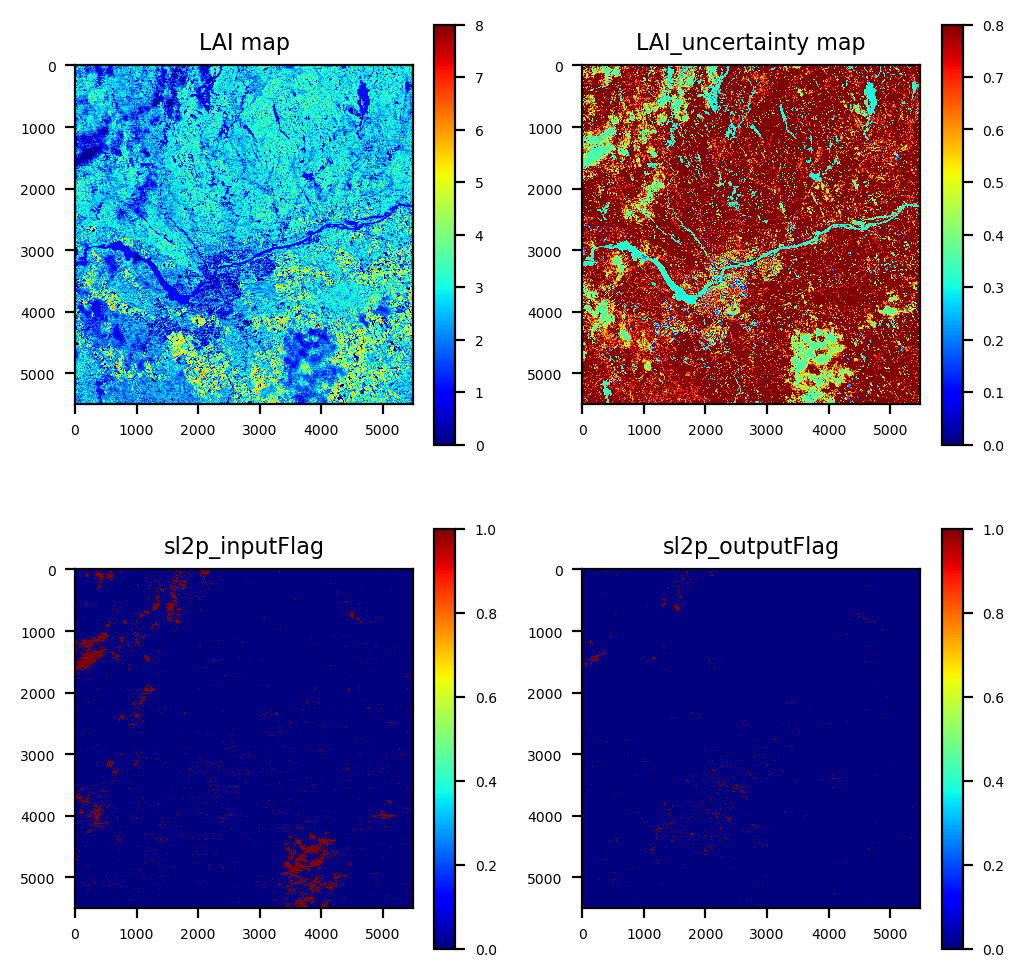

In [11]:
maxvar=dictionariesSL2P.make_outputParams()[variableName]['outputMax']
plt.rcParams.update({'font.size': 5})
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(6,6),dpi=200)

im1 = ax1.imshow(varmap[variableName],interpolation='nearest',vmin=0,vmax=maxvar,cmap='jet')
ax1.set_title(variableName+' map',fontsize=8)
fig.colorbar(im1, ax=ax1, orientation='vertical')

im2 = ax2.imshow(varmap[variableName+'_uncertainty'],interpolation='nearest',vmin=0,vmax=maxvar/10,cmap='jet')
ax2.set_title(variableName+'_uncertainty'+' map',fontsize=8)
fig.colorbar(im2, ax=ax2, orientation='vertical')

im3 = ax3.imshow(varmap['sl2p_inputFlag'],interpolation='nearest',vmin=0,vmax=1,cmap='jet')
ax3.set_title('sl2p_inputFlag',fontsize=8)
fig.colorbar(im3, ax=ax3, orientation='vertical')

im4 = ax4.imshow(varmap['sl2p_outputFlag'],interpolation='nearest',vmin=0,vmax=1,cmap='jet')
ax4.set_title('sl2p_outputFlag',fontsize=8)
fig.colorbar(im4, ax=ax4, orientation='vertical')


### 5- Mask cloud, shadow, water ...

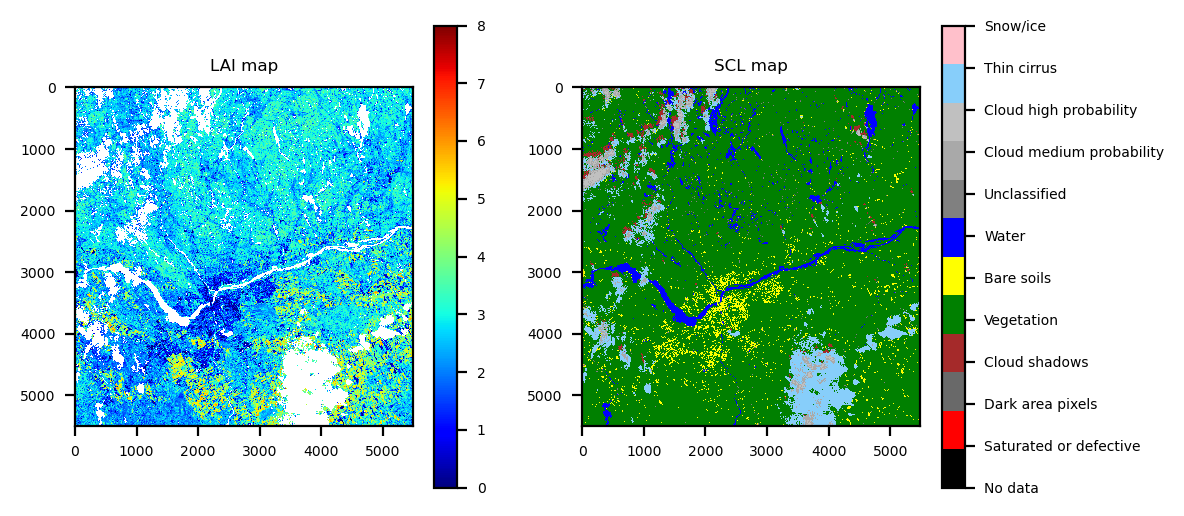

In [13]:
cmap =  ListedColormap(["black","red","dimgray","brown","green","yellow","Blue","gray","darkgray","silver","lightskyblue","pink"])
mask=numpy.where((s2['SCL']==4) | (s2['SCL']==5), 1, numpy.nan)
plt.rcParams.update({'font.size': 5})
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6,3),dpi=200)

im1 = ax1.imshow(varmap[variableName]*mask,interpolation='nearest',vmin=0,vmax=maxvar,cmap='jet')
ax1.set_title(variableName+' map')
fig.colorbar(im1, ax=ax1, orientation='vertical')

im2 = ax2.imshow(s2['SCL'],interpolation='nearest',vmin=0,vmax=11,cmap=cmap)
ax2.set_title('SCL map')
cbar=fig.colorbar(im2, ax=ax2, ticks=numpy.linspace(0, 11, 12),orientation='vertical')
cbar.ax.set_yticklabels(['No data','Saturated or defective','Dark area pixels','Cloud shadows','Vegetation','Bare soils','Water','Unclassified','Cloud medium probability','Cloud high probability','Thin cirrus','Snow/ice']);

### 6- Comparaison with SL2P-SNAP version product  
<div class="alert alert-block alert-warning">
<b>Note:</b> only applicable when using testdata (SL2P-SNAP products are available)</div>

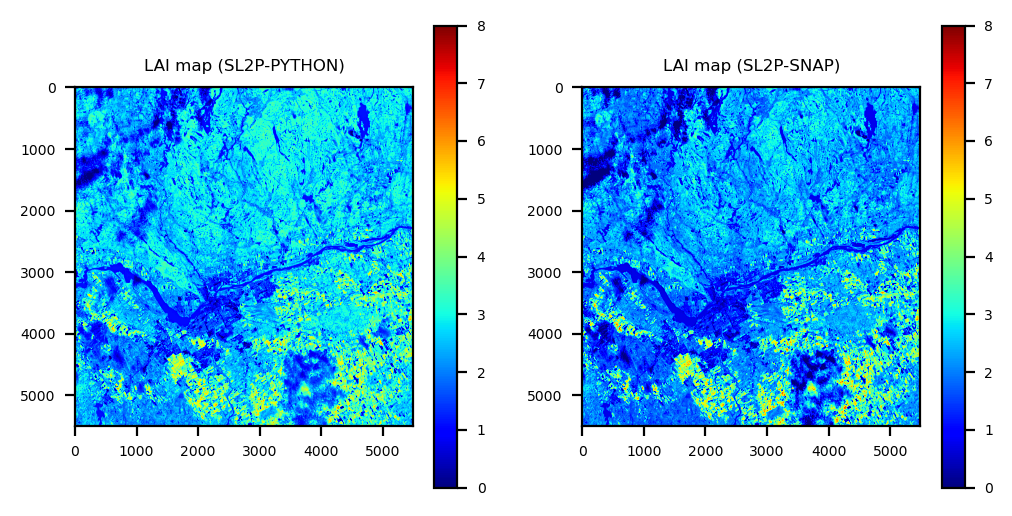

In [17]:
ref_path='./testdata/sl2p_snap_products/'
ref_fn=[ff for ff in os.listdir(ref_path) if variableName in ff][0]
with rasterio.open(ref_path+ref_fn) as rio:
    snap_sl2p_product=rio.read(1)
    
plt.rcParams.update({'font.size': 5})
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6,3),dpi=200)

im1 = ax1.imshow(varmap[variableName],vmin=0,vmax=maxvar,cmap='jet')
ax1.set_title(variableName+' map (SL2P-PYTHON)' )
fig.colorbar(im1, ax=ax1, orientation='vertical')

im2 = ax2.imshow(snap_sl2p_product,vmin=0,vmax=maxvar,cmap='jet')
ax2.set_title(variableName+' map (SL2P-SNAP)')
fig.colorbar(im2, ax=ax2, orientation='vertical')